# Plotting Functions

In [1]:
from pathlib import Path
import sys
sys.path.append('../src/rate')  # Go up one folder from notebooks/ and into src/
from constants import SCORED_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from treatment_effects import treatment_effects_pipeline
from utils_plotting import create_latex_tables_from_samples, plot_scores, naive_vs_RATE, rewrite_bias, synthetic_subplots, att_atu
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

2025-01-10 16:03:28,216 - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-01-10 16:03:28,217 - INFO - NumExpr defaulting to 16 threads.


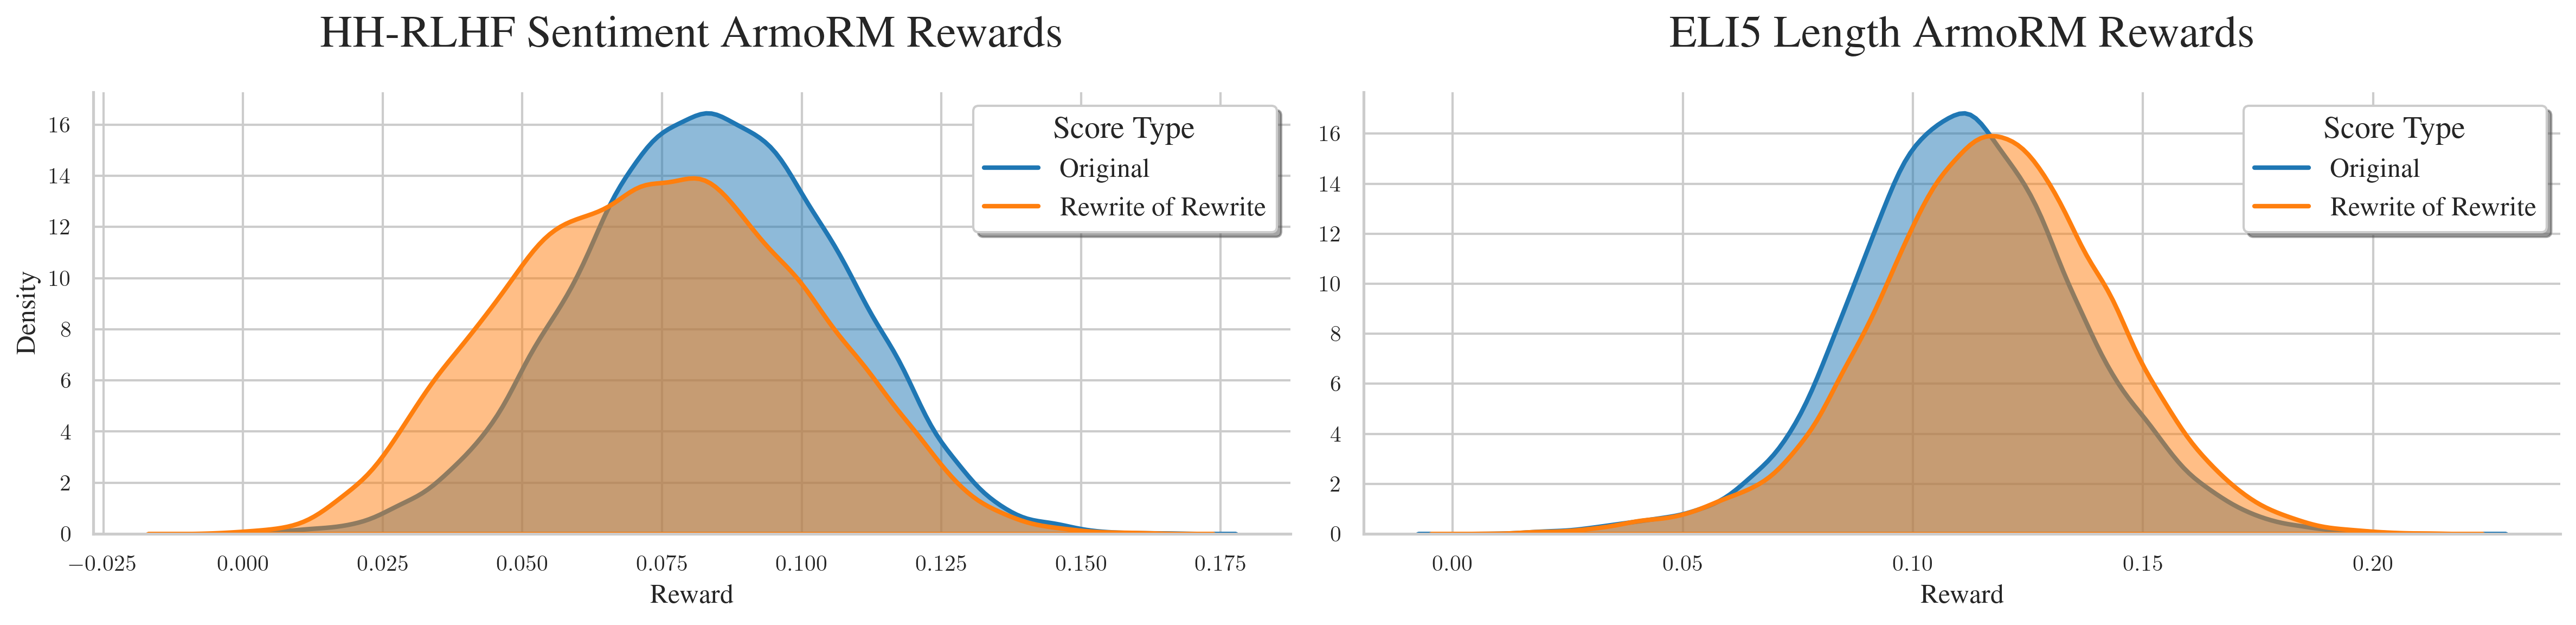

In [2]:
hh_rlhf_template = {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
eli5_template = {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    }

templates = [hh_rlhf_template, eli5_template]
plot_scores(templates, SCORED_DIR)

In [3]:
config = load_dataset_from_json(Path("config_plotting.jsonl"))

# make into list of dictionaries
experiment_templates = [value for value in config.values()]

In [4]:
# save all the data
effects_data = []
for effects_template in experiment_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    effects_data.append(effects)

2025-01-10 16:03:32,029 - INFO - Number of w=1 examples: 12612
2025-01-10 16:03:32,031 - INFO - Number of w=0 examples: 12389
2025-01-10 16:03:32,043 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': -0.0008267120345947232,
    'ATE_rewritten_rewrite_stderr': 0.00023309842563074148,
    'ATE_single_rewrite': 0.001494292597008548,
    'ATE_single_rewrite_stderr': 9.391197021986063e-05,
    'ATT_rewritten_rewrite': 0.0005248629986794456,
    'ATT_rewritten_rewrite_stderr': 0.0003215778627196273,
    'ATT_single_rewrite': -0.002639021079802975,
    'ATT_single_rewrite_stderr': 0.00010186583527184842,
    'ATU_rewritten_rewrite': -0.002202615200278285,
    'ATU_rewritten_rewrite_stderr': 0.0003354240091955926,
    'ATU_single_rewrite': 0.00570200525274725,
    'ATU_single_rewrite_stderr': 0.00014943376492016524,
    'Y0_count': 12389,
    'Y1_count': 12612,
    'naive_effect': 0.008119381960269595,
    'naive_effect_stderr': 0.0003128414498368806,
    'reward_std': 0.024745076474063

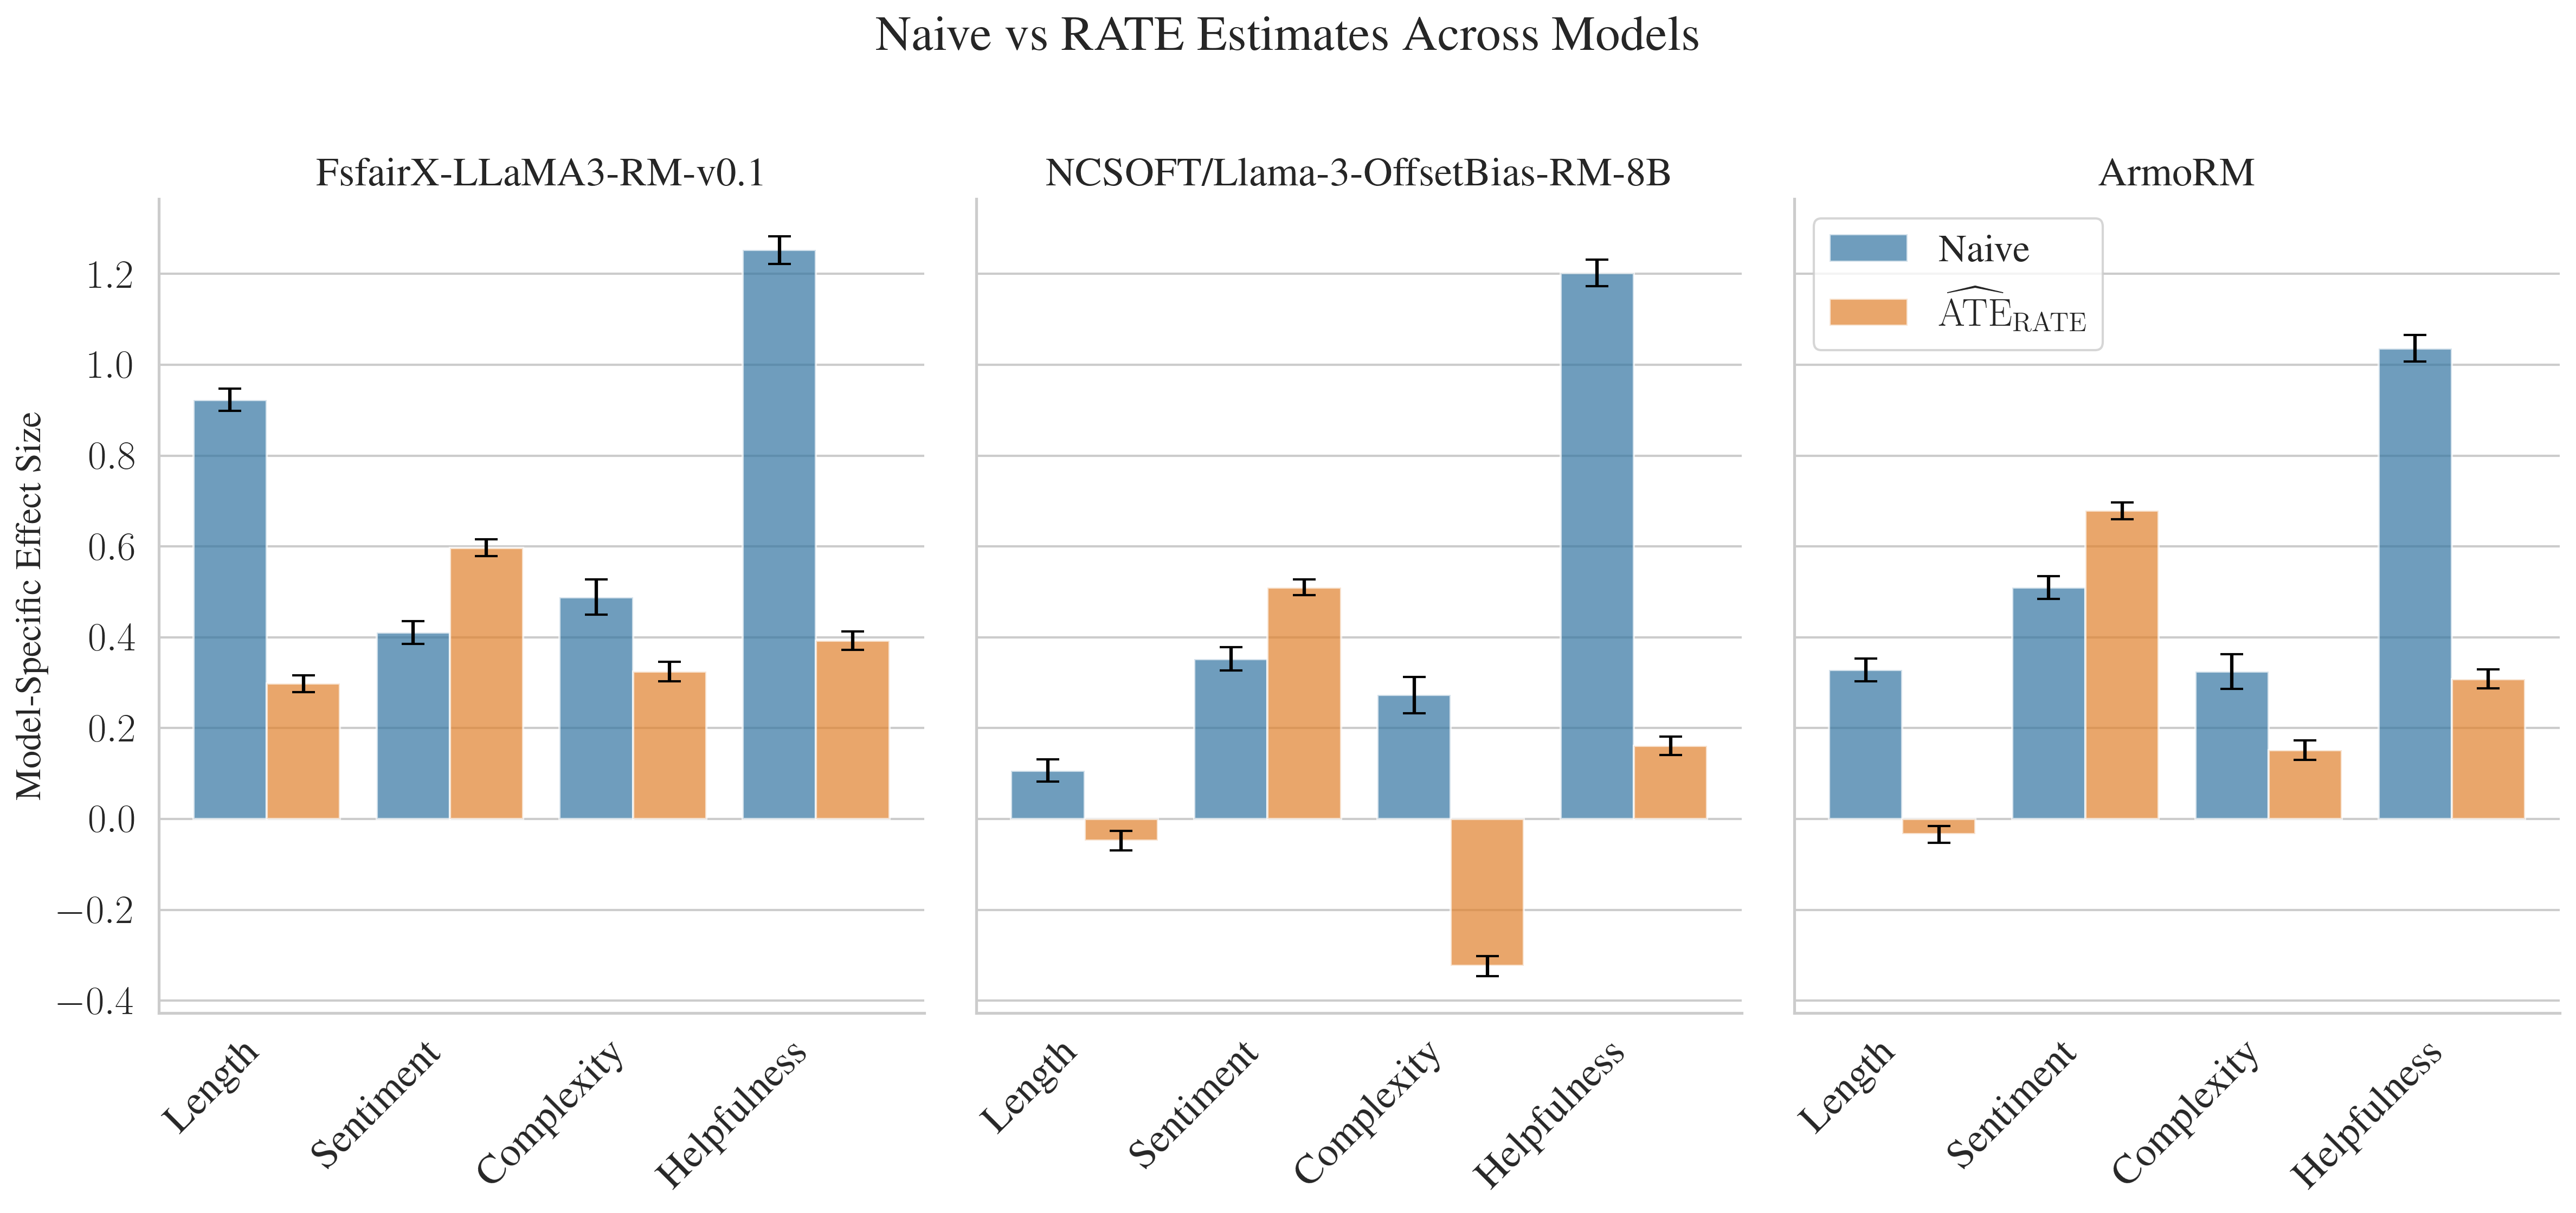

In [5]:
reward_models = ['FsfairX-LLaMA3-RM-v0.1', 'NCSOFT/Llama-3-OffsetBias-RM-8B', 'ArmoRM']
naive_vs_RATE(effects_data, experiment_templates, reward_models, normalize = 'reward_std')

In [6]:
effects_data

[{'naive_effect': 0.008119381960269595,
  'naive_effect_stderr': 0.0003128414498368806,
  'ATE_single_rewrite': 0.001494292597008548,
  'ATE_single_rewrite_stderr': 9.391197021986063e-05,
  'ATT_single_rewrite': -0.002639021079802975,
  'ATT_single_rewrite_stderr': 0.00010186583527184842,
  'ATU_single_rewrite': 0.00570200525274725,
  'ATU_single_rewrite_stderr': 0.00014943376492016524,
  'ATE_rewritten_rewrite': -0.0008267120345947232,
  'ATE_rewritten_rewrite_stderr': 0.00023309842563074148,
  'ATT_rewritten_rewrite': 0.0005248629986794456,
  'ATT_rewritten_rewrite_stderr': 0.0003215778627196273,
  'ATU_rewritten_rewrite': -0.002202615200278285,
  'ATU_rewritten_rewrite_stderr': 0.0003354240091955926,
  'reward_std': 0.02474507647406317,
  'Y1_count': 12612,
  'Y0_count': 12389},
 {'naive_effect': 0.11935827661152754,
  'naive_effect_stderr': 0.014139665123064703,
  'ATE_single_rewrite': 0.07064954706499282,
  'ATE_single_rewrite_stderr': 0.00481090758409154,
  'ATT_single_rewrite': 

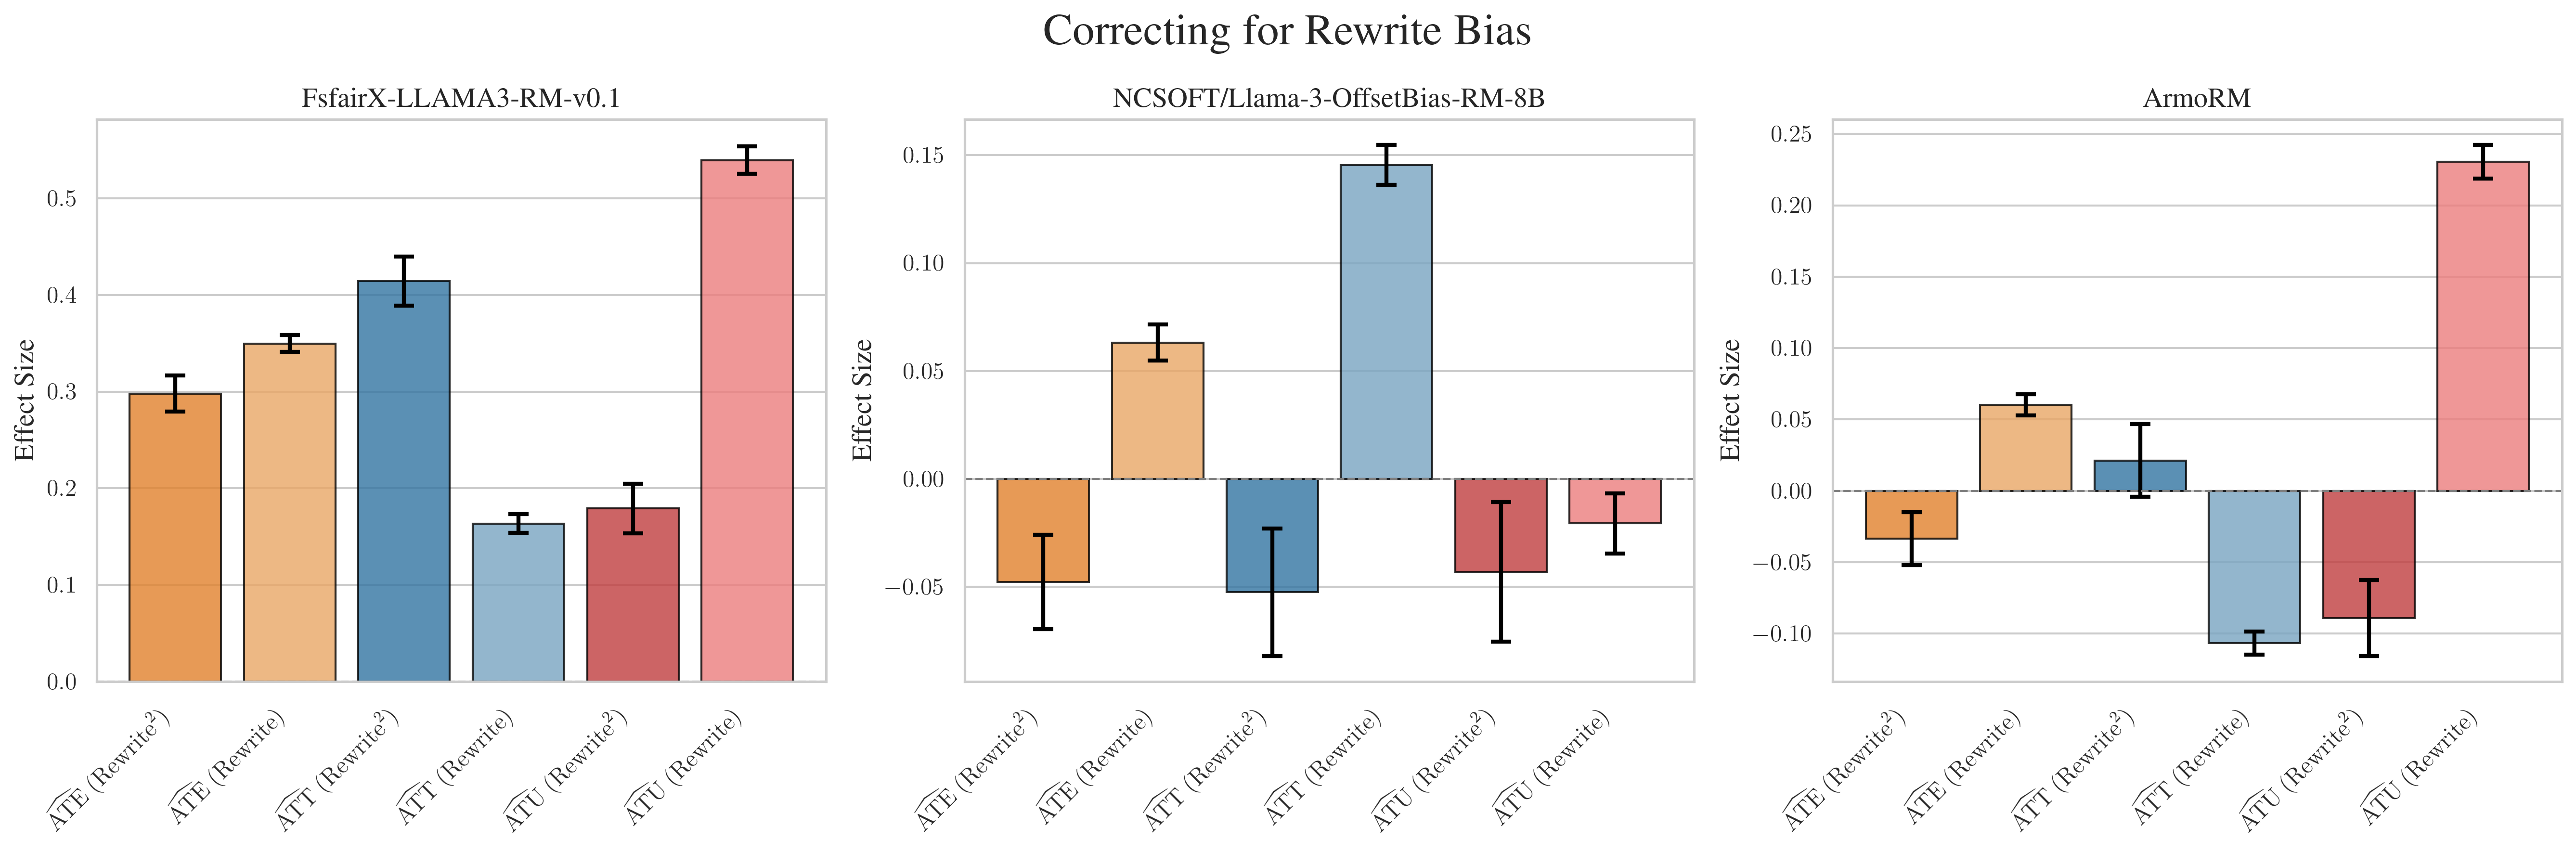

In [7]:
# reverse effects_data[0:3]
reversed_data = effects_data[0:3][::-1]

# Titles for each subplot
titles = [
    "FsfairX-LLAMA3-RM-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "ArmoRM"
]
rewrite_bias(reversed_data, titles)

In [8]:
config = load_dataset_from_json(Path("config_plotting_synth.jsonl"))

# make into list of dictionaries
synthetic_templates = [value for value in config.values()]

In [9]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    synthetic_data.append(effects)

2025-01-10 16:03:42,464 - INFO - Number of w=1 examples: 4004
2025-01-10 16:03:42,465 - INFO - Number of w=0 examples: 5372
2025-01-10 16:03:42,470 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.0844035465969567,
    'ATE_rewritten_rewrite_stderr': 0.04930379836414409,
    'ATE_single_rewrite': 0.16884899790376523,
    'ATE_single_rewrite_stderr': 0.01354892736882799,
    'ATT_rewritten_rewrite': 0.2384955123230651,
    'ATT_rewritten_rewrite_stderr': 0.06947906261246611,
    'ATT_single_rewrite': -0.330754465871043,
    'ATT_single_rewrite_stderr': 0.01630709816868453,
    'ATU_rewritten_rewrite': -0.0304483206344911,
    'ATU_rewritten_rewrite_stderr': 0.0685568950220651,
    'ATU_single_rewrite': 0.5412265610002531,
    'ATU_single_rewrite_stderr': 0.01873701381382012,
    'Y0_count': 5372,
    'Y1_count': 4004,
    'naive_effect': -0.2572232905938362,
    'naive_effect_stderr': 0.06290409599455854,
    'reward_std': 3.068588378397191}
2025-01-10 16:03:42,471 - INFO - Ca

In [10]:
config = load_dataset_from_json(Path("config_plotting_help_synth.jsonl"))

# make into list of dictionaries
help_synthetic_templates = [value for value in config.values()]

In [11]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    help_synthetic_data.append(effects)

2025-01-10 16:03:44,400 - INFO - Number of w=1 examples: 2574
2025-01-10 16:03:44,402 - INFO - Number of w=0 examples: 2574
2025-01-10 16:03:44,405 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.014393984818637143,
    'ATE_rewritten_rewrite_stderr': 0.00079378864033712,
    'ATE_single_rewrite': 0.01957111698185457,
    'ATE_single_rewrite_stderr': 0.0005043422673346951,
    'ATT_rewritten_rewrite': 0.0054083771461102825,
    'ATT_rewritten_rewrite_stderr': 0.0011309362696518663,
    'ATT_single_rewrite': 0.04116395636899113,
    'ATT_single_rewrite_stderr': 0.0006486281561102675,
    'ATU_rewritten_rewrite': 0.02337959249116403,
    'ATU_rewritten_rewrite_stderr': 0.0010911649065769267,
    'ATU_single_rewrite': -0.002021722405281992,
    'ATU_single_rewrite_stderr': 0.00048425794318990095,
    'Y0_count': 2574,
    'Y1_count': 2574,
    'naive_effect': 0.031895498183147755,
    'naive_effect_stderr': 0.000981691571743384,
    'reward_std': 0.03521797135263725}
2025-01-10

Slope of $\widehat{\mathrm{ATE}}\ (\mathrm{Rewrite}^2)$: 0.08263729229910469
Slope of $\widehat{\mathrm{ATE}}\ (\mathrm{Single\ Rewrite})$: -0.27469109291736626
Slope of $\widehat{\mathrm{ATE}}\ (\mathrm{Rewrite}^2)$: -0.0005697298211597665
Slope of $\widehat{\mathrm{ATE}}\ (\mathrm{Single\ Rewrite})$: -0.0016832499914813447


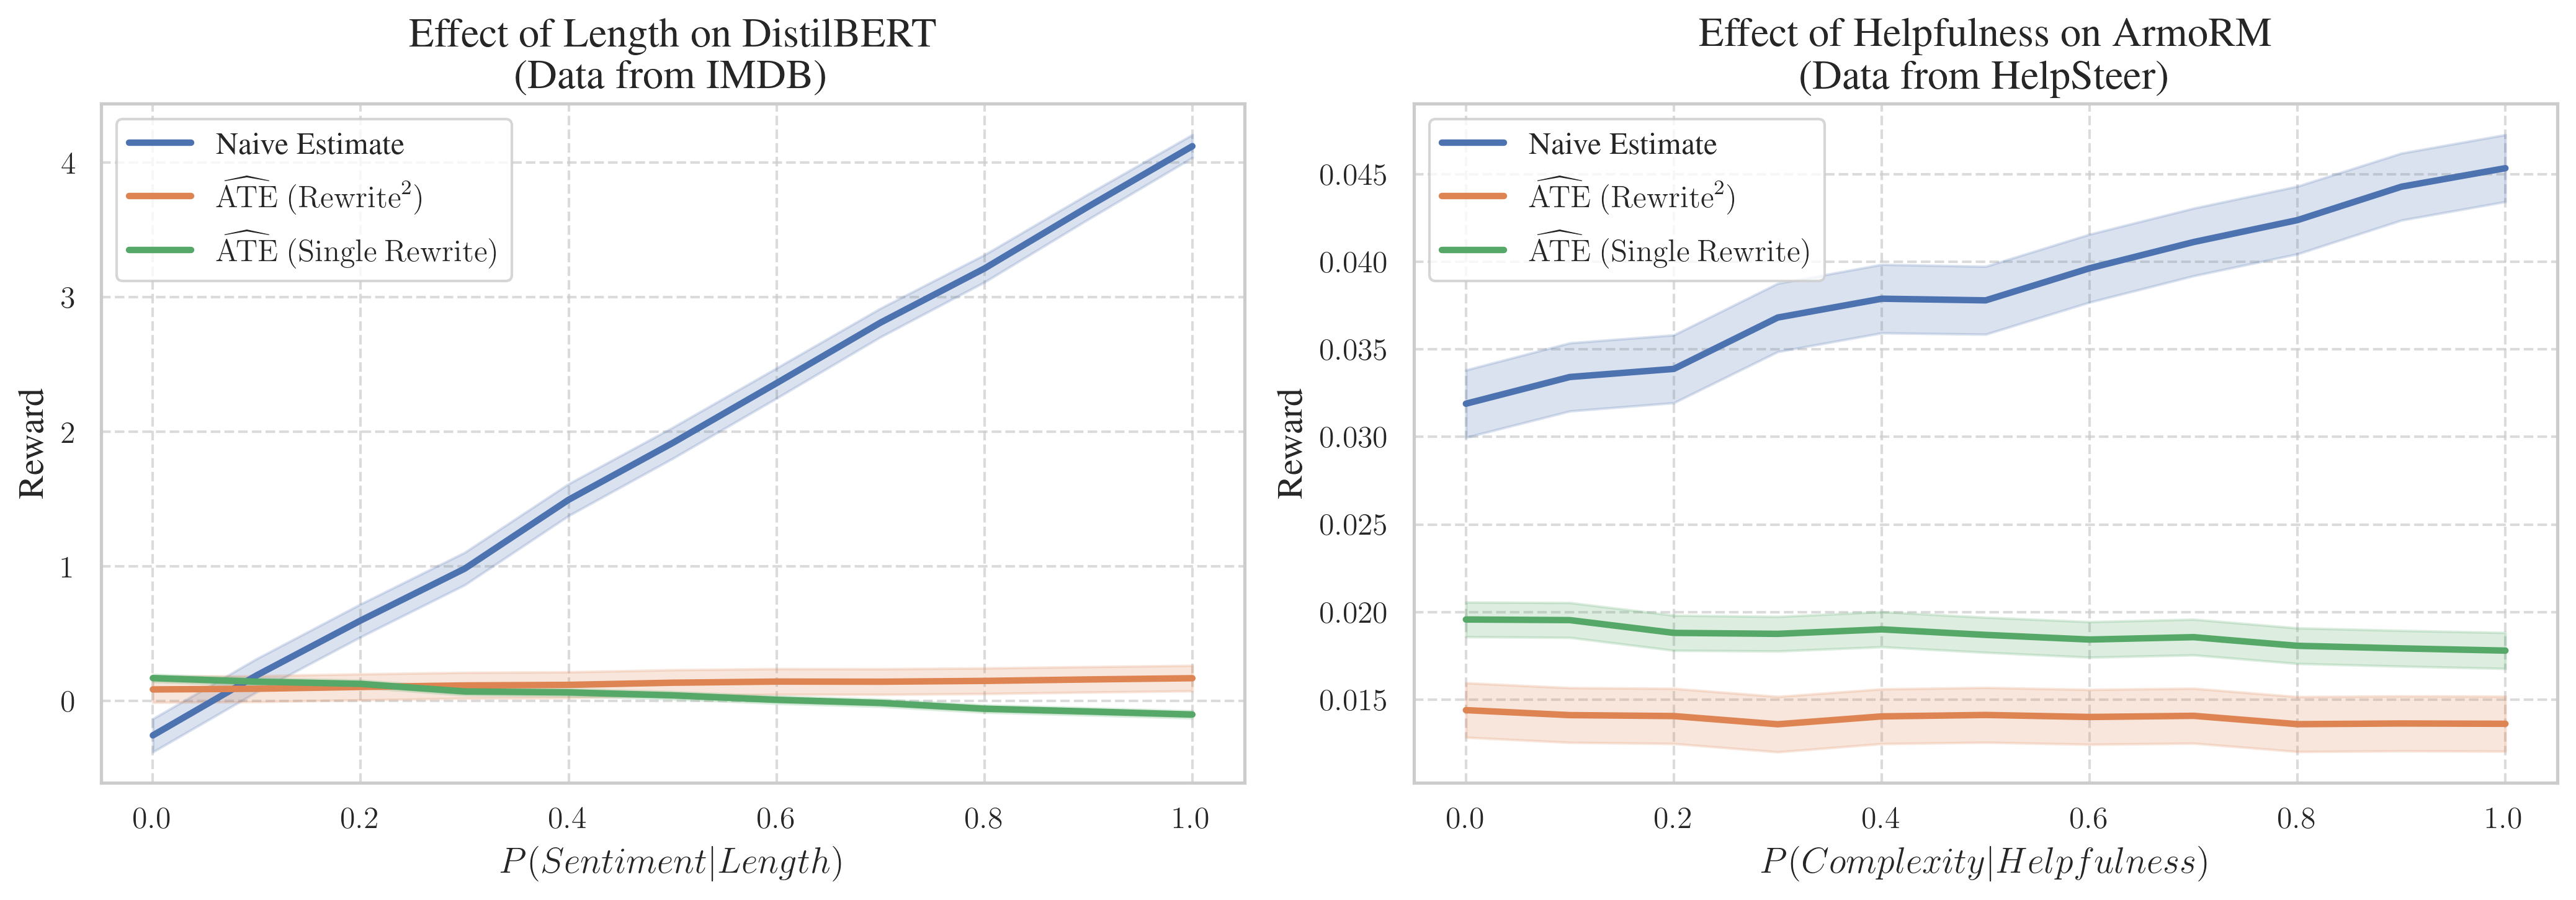

In [12]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")

Next we compare the RATE ATT vs ATU estimates for a particular tuple, also normalized.

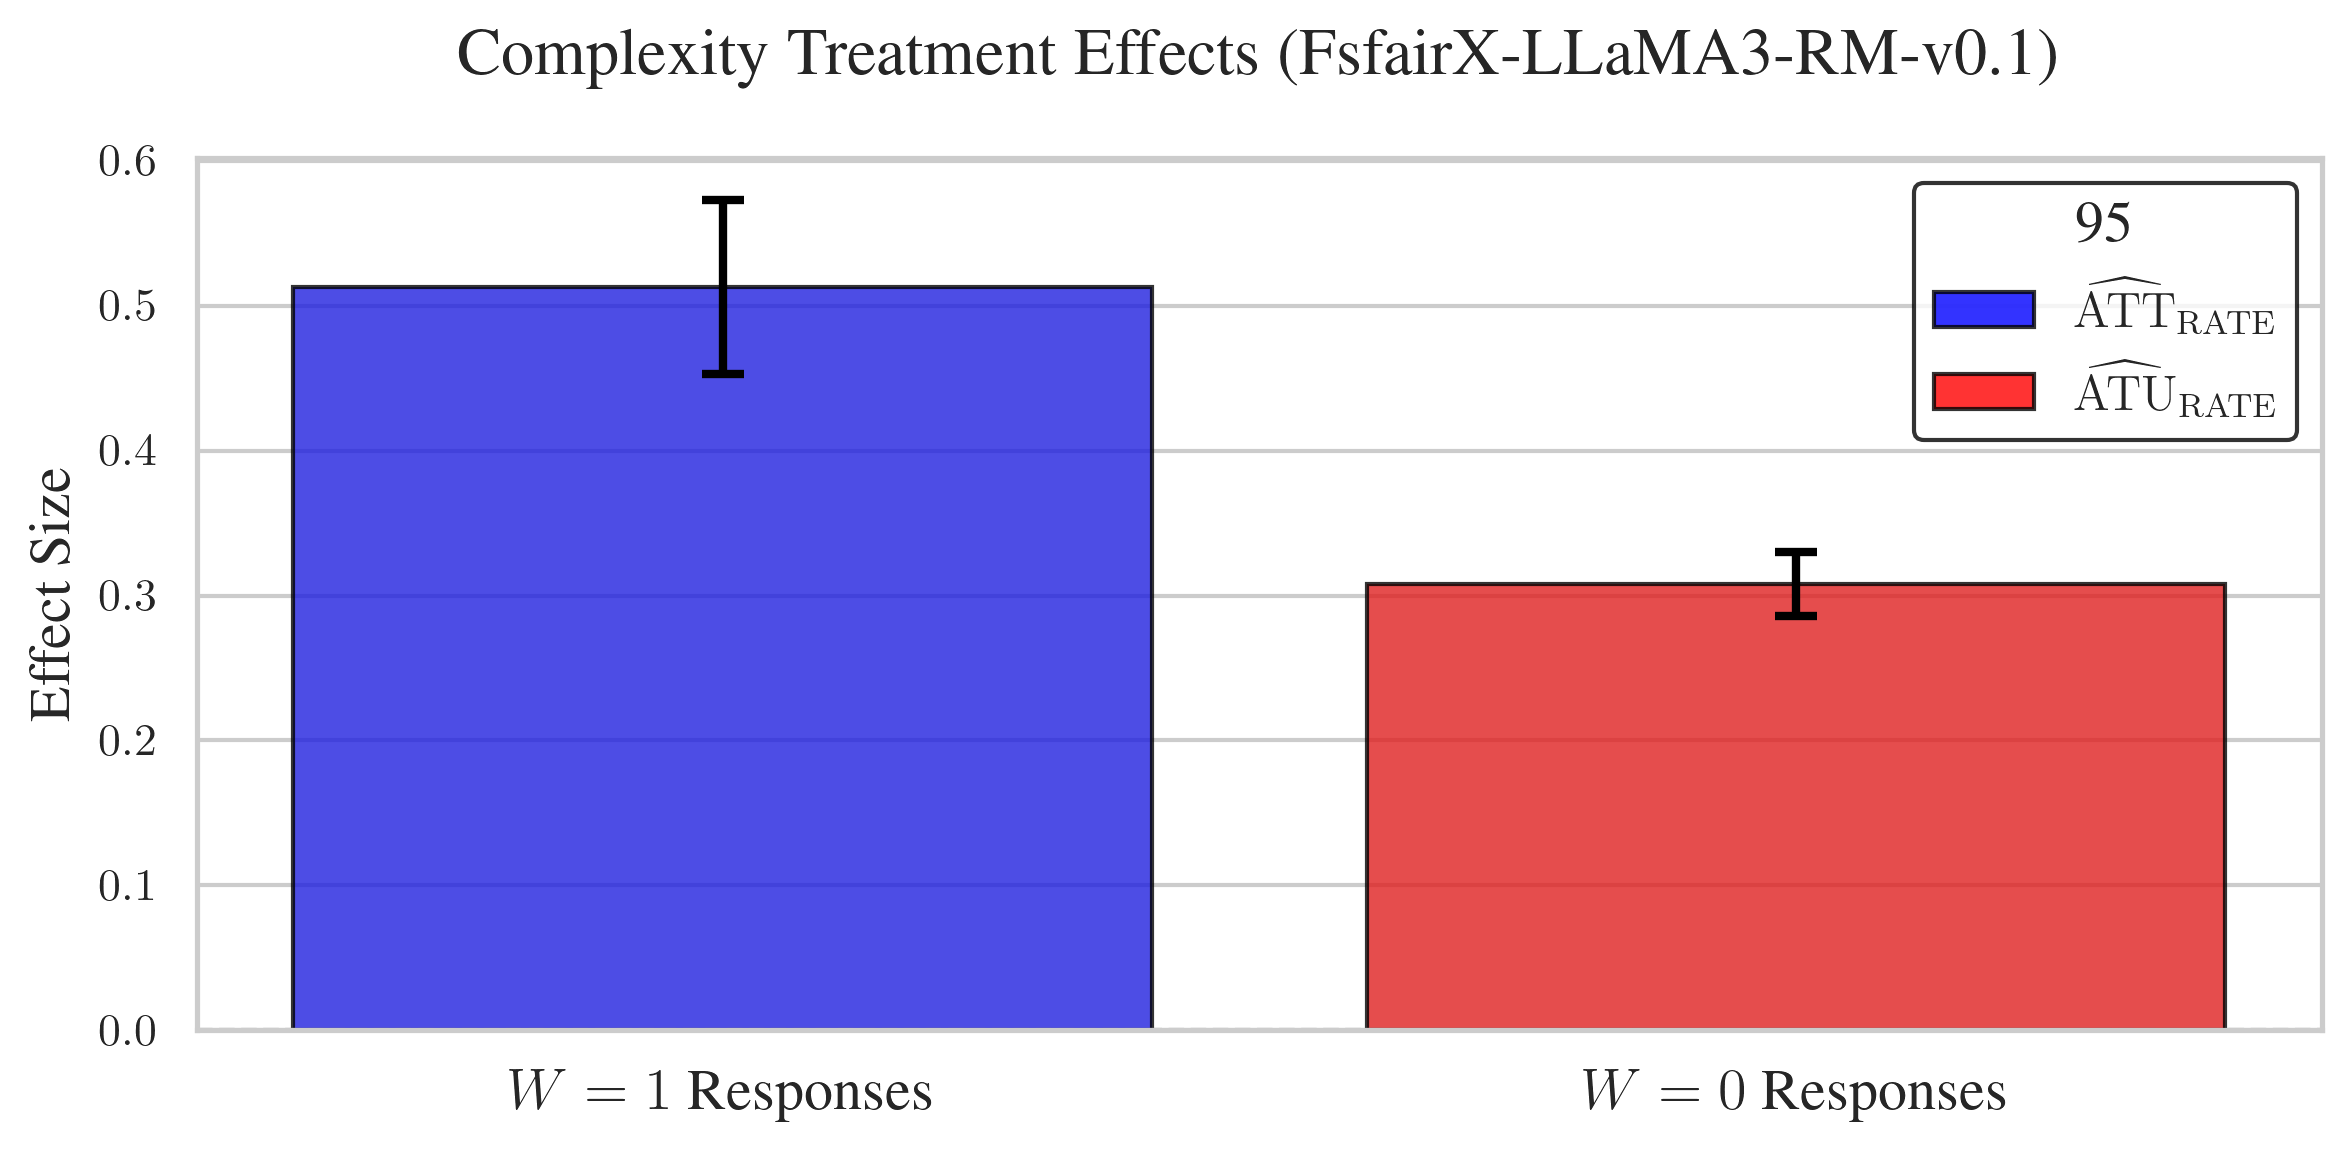

In [13]:
model_name = "FsfairX-LLaMA3-RM-v0.1"
att_atu(effects_data[8], effects_data[8]['reward_std'], model_name)